# Comparing kraken and kraken kraken output

Run in 24hr_env environment
 
- Looking at 2 barcodes 27 (sample 33) & 28 (sample 35)
- Want to compare the identified taxa by the classifications
- Compare at species and genus level, number of classified species
- Would be good to also bring in the PHIbase minimap data - note this hasn't been filtered

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import operator

## Start by reading in the data

In [46]:
meta = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/CF_2023_metadata.csv")

#Cleaning the metadata
meta[['DNA extracted?', 'WGA date', 'Initial bead clean up']] = meta[
    ['DNA extracted?', 'WGA date', 'Initial bead clean up']].apply(
        lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

#This is assuming where I don't know the date of collection it's on the 14th of the month as that's the middle

def parse_dates(x):
    try:
        # If the date is in 'mmm-yy' format, add '14-' to the start to make it 'dd-mmm-yy'
        if '-' in x and len(x) == 6:
            x = '14-' + x

        return parse(x, dayfirst=True)
    except:
        return pd.NaT

meta['Date collected'] = meta['Date collected'].apply(parse_dates)

contig_stats = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_contig_stats.csv")
contig_stats = contig_stats.replace(',', '', regex=True)
cols = ['Basecalled reads', 'Passed filter & analysed', 'Classified reads', 'Unclassified reads']
contig_stats[cols] = contig_stats[cols].astype(int)

In [47]:
kraken = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/blast/compare_taxa_assignments_lca_0.1_all_levels_2024-SEP-6_11-30-21.csv")

kraken_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/kraken/compare_taxa_assignments_lca_0.1_all_levels_2024-SEP-6_11-30-21_taxaID_lineage.csv")
kraken_lineage = kraken_lineage.drop(0) #removing the first row 
kraken_lineage['NCBI ID'] = kraken_lineage['NCBI ID'].astype('int64')

#Creating assigned read count dataframe
columns_to_keep = [col for col in kraken.columns if 'Summed' not in col]
kraken_assi = kraken[columns_to_keep]

# The string to be removed
string_to_remove = " (kraken_flush) Read count"

# Modify all column headers to remove the specified string
kraken_assi.columns = [col.replace(string_to_remove, '') for col in kraken_assi.columns]

#Melt the data to long
kraken_assi_long = kraken_assi.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)
kraken_assi_long['Taxon']=kraken_assi_long['Name']

kraken_assi_long['Sample'] = kraken_assi_long['Sample'].astype('int64')

#Add lineage data and merge on NCBI ID
kraken_lin_merge = kraken_assi_long.merge(kraken_lineage, how='right')

# #Add metadata and merge on sample which is Number in metadata
meta = meta.rename(columns={'Number': 'Sample'})
filtered_meta = meta[meta['Sample'].isin([33, 35])]
kraken_lin_meta_merge = kraken_lin_merge.merge(filtered_meta, how='right')

# #Add contig stats and merge on sample
filtered_contig_stats = contig_stats[contig_stats['Sample'].isin([33, 35])]
kraken_all_data = kraken_lin_meta_merge.merge(filtered_contig_stats, how='right', on='Sample')

# Create column for relative abundance
kraken_all_data["rel_abundance"] = (kraken_all_data["read count"] / kraken_all_data["Basecalled reads"]) * 100

,Name,NCBI ID,NCBI Rank,Sample,read count,Taxon,kingdom,phylum,class,order,...,WGA BR kit(ug/nL)_y,NumContigs,TotalSum,N50Length,Basecalled yield (Gb),Basecalled reads,Passed filter & analysed,Classified reads,Unclassified reads,rel_abundance
0,unclassified,0,no rank,33,87853,unclassified,NaN,NaN,NaN,NaN,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,55.257630
1,root,1,no rank,33,28,root,Unassigned,Unassigned,Unassigned,Unassigned,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.017611
2,Bacteria,2,superkingdom,33,1093,Bacteria,Bacteria,Unassigned,Unassigned,Unassigned,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.687473
3,Shewanella,22,genus,33,21,Shewanella,Bacteria,Pseudomonadota,Gammaproteobacteria,Alteromonadales,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.013209
4,Myxococcales,29,order,33,0,Myxococcales,Bacteria,Myxococcota,Myxococcia,Myxococcales,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,Polyangiales,3031712,order,35,0,Polyangiales,Bacteria,Myxococcota,Unassigned,Polyangiales,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.000000
1704,Epsilonproteobacteria,3031852,class,35,0,Epsilonproteobacteria,Bacteria,Campylobacterota,Epsilonproteobacteria,Unassigned,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.000000
1705,Comamonas sp. ZM22,3046670,species,35,52,Comamonas sp. ZM22,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.022129
1706,Paenacidovorax,3051138,genus,35,0,Paenacidovorax,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.000000


In [67]:
blast = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_marti_lca_0.1_all_levels_2024-FEB-22_10-25-17.csv")

blast_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/flush_experiment_marti_lca_0.1_all_levels_2024-FEB-22_10-25-17_taxaID_lineage.csv")
blast_lineage = blast_lineage.drop(0) #removing the first row
blast_lineage['NCBI ID'] = blast_lineage['NCBI ID'].astype('int64')

#Creating assigned read count dataframe
columns_to_keep = [col for col in blast.columns if 'Summed' not in col]
blast_assi = blast[columns_to_keep]

# The string to be removed
string_to_remove = " (flush_expmnt_160124) Read count"

# Modify all column headers to remove the specified string
blast_assi.columns = [col.replace(string_to_remove, '') for col in blast_assi.columns]

#Melt the data to long
blast_assi_long = blast_assi.melt(
    id_vars = ['Taxon', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

blast_assi_long['Sample'] = blast_assi_long['Sample'].astype('int64')

#Add lineage data and merge on NCBI ID
blast_lin_merge = blast_assi_long.merge(blast_lineage, how='right')

# #Add metadata and merge on sample which is Number in metadata
meta = meta.rename(columns={'Number': 'Sample'})
filtered_meta = meta[meta['Sample'].isin([33, 35])]
blast_lin_meta_merge = blast_lin_merge.merge(filtered_meta, how='right')

# #Add contig stats and merge on sample
filtered_contig_stats = contig_stats[contig_stats['Sample'].isin([33, 35])]
blast_all_data = blast_lin_meta_merge.merge(filtered_contig_stats, how='right', on='Sample')

# Create column for relative abundance
blast_all_data["rel_abundance"] = (blast_all_data["read count"] / blast_all_data["Basecalled reads"]) * 100
blast_all_data

,Taxon,NCBI ID,NCBI Rank,Sample,read count,kingdom,phylum,class,order,family,...,WGA BR kit(ug/nL)_y,NumContigs,TotalSum,N50Length,Basecalled yield (Gb),Basecalled reads,Passed filter & analysed,Classified reads,Unclassified reads,rel_abundance
0,unclassified,0,no rank,33,67685,NaN,NaN,NaN,NaN,NaN,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,42.572395
1,root,1,no rank,33,598,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.376129
2,Bacteria,2,superkingdom,33,67,Bacteria,Unassigned,Unassigned,Unassigned,Unassigned,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.042142
3,Phenylobacterium,20,genus,33,0,Bacteria,Pseudomonadota,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.000000
4,Myxococcales,29,order,33,0,Bacteria,Myxococcota,Myxococcia,Myxococcales,Unassigned,...,144.0,158988,335701973,4739,0.336,158988,104038,36353,67685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,Sphingomonas sp. CV7422,3018036,species,35,464,Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.197456
2114,Cyanophyceae,3028117,class,35,0,Bacteria,Cyanobacteriota,Cyanophyceae,Unassigned,Unassigned,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.000000
2115,Ardenticatenia incertae sedis,3036629,no rank,35,0,Bacteria,Chloroflexota,Ardenticatenia,Unassigned,Unassigned,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.000000
2116,Paracidovorax,3051137,genus,35,0,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Comamonadaceae,...,16.1,234989,581134397,5224,0.581,234989,169061,89114,79947,0.000000


In [15]:
pathogen = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/PHIbase/fl_exp_all_taxaID_count.tsv",  sep='\t' , header=None)
pathogen.columns = ['taxid', 'count', 'barcode']

#Read in the lineage data for PHIbase and only retain unique rows
pathogen_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/flush_experiment_160124/PHIbase/fl_exp_taxaID_lineage_sep_head.csv")


## Some graphs

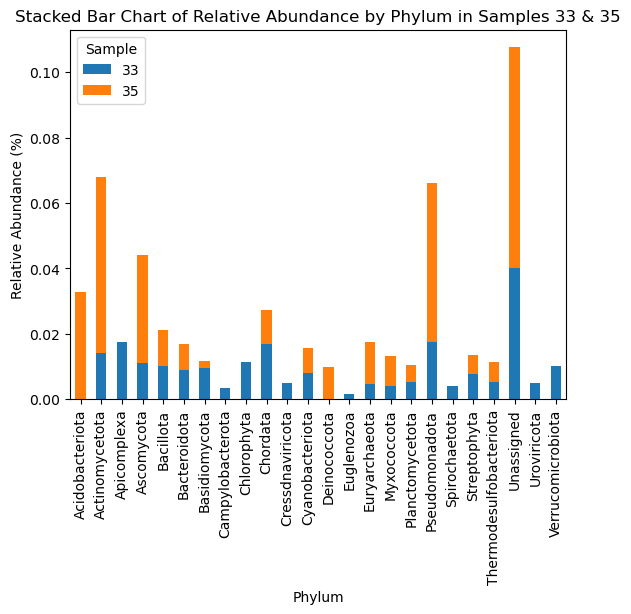

In [50]:
# Pivot data to get samples as columns and phyla as rows, with relative abundance as values
df_pivot = blast_all_data.pivot_table(index='phylum', columns='Sample', values='rel_abundance', fill_value=0)

# Plotting the stacked bar chart
df_pivot.plot(kind='bar', stacked=True)

# Adding labels and title
plt.ylabel('Relative Abundance (%)')
plt.xlabel('Phylum')
plt.title('Stacked Bar Chart of Relative Abundance by Phylum')

# Show plot
plt.show()


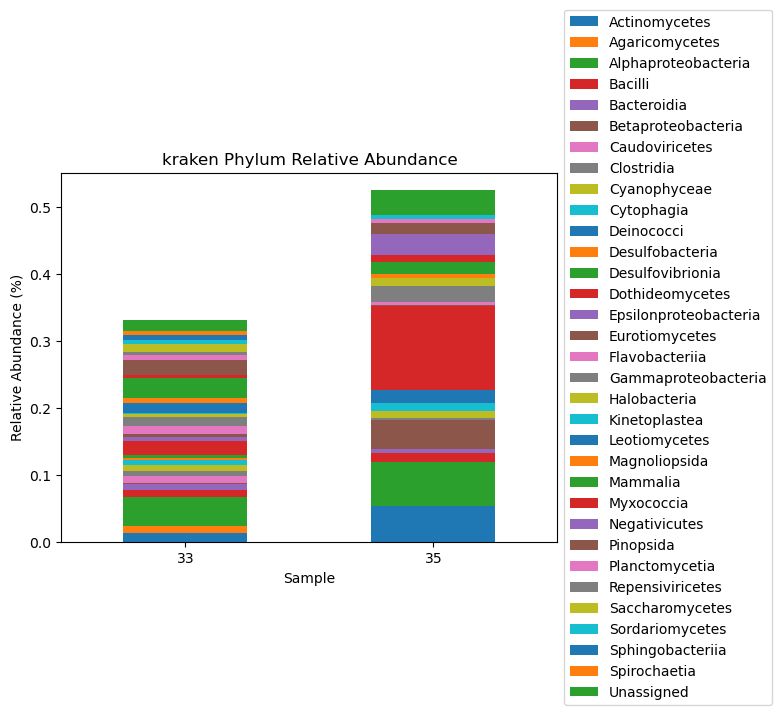

In [69]:
# Pivot data to get the samples (33 and 35) as columns and the phyla as the row index
df_pivot = kraken_all_data.pivot_table(index='phylum', columns='Sample', values='rel_abundance', fill_value=0)

# Sort the data within each sample by relative abundance
df_pivot = df_pivot.apply(lambda x: x.sort_values(ascending=False), axis=0)

# Transpose the data so that samples (33 and 35) are the index, and phyla are the columns
df_pivot = df_pivot.T

# Plotting the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True)

# Adding labels and title
plt.ylabel('Relative Abundance (%)')
plt.xlabel('Sample')
plt.title('kraken Phylum Relative Abundance')

# Move the legend to the left of the graph
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate x-axis labels to be upright
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Show plot
plt.show()


Same plot but with blast data

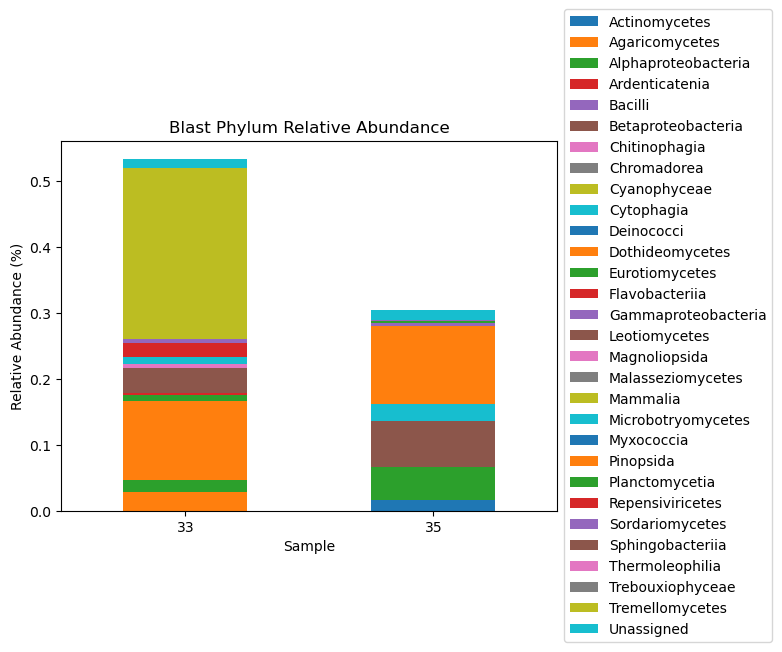

In [70]:
# Pivot data to get the samples (33 and 35) as columns and the phyla as the row index
df_pivot = blast_all_data.pivot_table(index='phylum', columns='Sample', values='rel_abundance', fill_value=0)

# Sort the data within each sample by relative abundance
df_pivot = df_pivot.apply(lambda x: x.sort_values(ascending=False), axis=0)

# Transpose the data so that samples (33 and 35) are the index, and phyla are the columns
df_pivot = df_pivot.T

# Plotting the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True)

# Adding labels and title
plt.ylabel('Relative Abundance (%)')
plt.xlabel('Sample')
plt.title('Blast Phylum Relative Abundance')

# Move the legend to the left of the graph
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate x-axis labels to be upright
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Show plot
plt.show()

## Combining blast & kraken data

This code needs work

In [76]:
# Add classifier columns
kraken_all_data['classifier'] = 'Kraken'
blast_all_data['classifier'] = 'Blast'

# Merge the datasets on the 'taxid' column, retaining both versions of overlapping columns
merged_data = pd.merge(kraken_all_data, blast_all_data, on='NCBI ID', how='inner', suffixes=('_kra', '_bla'))



KeyError: 'rel_abundance'